In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import random
import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.core.repair import Repair

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d, Axes3D

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

###########
from skopt.space import Space
from skopt.sampler import Lhs

In [2]:
def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

def optimize_nsga3_noconstr(problem, ref_point,  initial_x, # must haves
                            N_BATCH, pop_size,
                            ref_num=10, # as a rule of thumb, pop_size>ref_num,
                            noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = UNSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        
    ##########
    
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    iterdict = {}
    a = 0
    b = initial_x.shape[0]
    for i in range(0, N_BATCH+1):

        iterdict[i] = (a, b)
        # a stays at zero
        b+=pop_size
    
    for i in range(0,N_BATCH):
        hvs_obj = train_obj[iterdict[i][0]:iterdict[i][1]]

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(hvs_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = hvs_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
                
        hvs.append(volume)   
        
    ##########
     
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [3]:
gp_dict = joblib.load('gp_dict ')
xscaler = joblib.load('xscaler')
yscaler = joblib.load('yscaler')

df = pd.read_csv('dataset.csv')

df

,sample,x0: fuel to oxidizer ratio,x1: acac amount,x2: total concentration,x3: temperature,conductance - mean,conductance - std,XRF-normalized conductance - mean,XRF-normalized conductance - std,Conductivity - mean
0,1,2.182154,0.494205,0.005910,220.000000,0.025874,0.025008,2.020000e-07,7.120000e-08,27.919596
1,2,0.559675,0.668397,0.011784,260.000000,0.001355,0.007987,2.010000e-07,1.450000e-07,27.761720
2,3,2.048849,1.000000,0.011971,200.000000,0.010435,0.035914,7.070000e-08,7.410000e-08,9.775639
3,4,0.573775,0.000000,0.005906,220.000000,0.084796,0.063401,4.600000e-07,1.110000e-07,63.552821
4,5,1.135546,0.101274,0.011734,260.000000,0.102472,0.080957,2.870000e-07,5.940000e-08,39.665750
...,...,...,...,...,...,...,...,...,...,...
190,191,0.825526,0.768592,0.006275,212.789993,0.060510,0.114109,3.860000e-07,1.180000e-07,53.415423
191,192,1.149512,0.882235,0.009971,210.978149,0.219133,1.619872,1.470000e-07,1.080000e-07,20.252462
192,193,1.474650,0.874811,0.010690,241.064728,0.001776,0.008784,5.350000e-08,5.350000e-08,7.395861
193,194,0.676297,0.572279,0.008611,230.326721,0.122352,0.338726,2.180000e-07,1.110000e-07,30.193197


In [4]:
'''
define the problem statement and objective function, using the regressor we previously trained
although there exists tool to infer ref point, we can take origin 0 as a good start
this is also what the paper did
'''

lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 4
    n_obj = 2
    n_constr = 0
    
    ref_point = torch.tensor([1.019, -0.048], **tkwargs) # has to be inverse of outputs, since it gets flipped back later
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        
        y1 = -X[...,3] # flip
        y2 = gp_dict.predict(X.cpu().numpy())
        y2_tensor = torch.tensor(y2, **tkwargs)
        
        output = torch.stack([y1,y2_tensor], axis=1)
        
        return output

In [5]:
N_BATCH = 100
BATCH_SIZE = 8
trial = 1

initial_x = draw_sobol_samples(bounds=Problem.bounds,n=1, q=2*(Problem.n_var+1), seed=trial).squeeze(0)

hvs_qnehvi, train_qnehvi = optimize_qnehvi_noconstr(Problem, Problem.ref_point, initial_x,
                                                   N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                                                   random_state=1, noise=0, verbose=True)

hvs_nsga3, train_nsga3 = optimize_nsga3_noconstr(Problem, Problem.ref_point, initial_x,
                                        N_BATCH=N_BATCH, pop_size=BATCH_SIZE, ref_num=BATCH_SIZE,
                                        random_state=1, noise=0, verbose=True)

Optimizing with qNEHVI


C:\Users\user\anaconda3\lib\site-packages\botorch\fit.py:143: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\user\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  warnings.warn(w.message, w.category)
C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, 

Batch  1 of 100: Hypervolume = 0.28, time = 5.56s.
Batch  2 of 100: Hypervolume = 0.39, time = 5.87s.
Batch  3 of 100: Hypervolume = 0.41, time = 7.28s.
Batch  4 of 100: Hypervolume = 0.41, time = 3.14s.
Batch  5 of 100: Hypervolume = 0.42, time = 8.49s.
Batch  6 of 100: Hypervolume = 0.45, time = 9.49s.
Batch  7 of 100: Hypervolume = 0.46, time = 9.96s.
Batch  8 of 100: Hypervolume = 0.47, time = 8.18s.
Batch  9 of 100: Hypervolume = 0.48, time = 3.26s.
Batch 10 of 100: Hypervolume = 0.49, time = 10.54s.
Batch 11 of 100: Hypervolume = 0.49, time = 2.15s.
Batch 12 of 100: Hypervolume = 0.49, time = 2.89s.
Batch 13 of 100: Hypervolume = 0.51, time = 10.08s.
Batch 14 of 100: Hypervolume = 0.52, time = 2.44s.
Batch 15 of 100: Hypervolume = 0.53, time = 1.90s.
Batch 16 of 100: Hypervolume = 0.54, time = 3.20s.
Batch 17 of 100: Hypervolume = 0.55, time = 2.06s.
Batch 18 of 100: Hypervolume = 0.55, time = 2.36s.
Batch 19 of 100: Hypervolume = 0.55, time = 1.72s.
Batch 20 of 100: Hypervolume 

   69 |     554 |       6 |  0.001999163 |            f
   70 |     562 |       6 |  0.001443101 |            f
   71 |     570 |       5 |  0.000611470 |            f
   72 |     578 |       6 |  0.026068020 |            f
   73 |     586 |       6 |  0.00000E+00 |            f
   74 |     594 |       6 |  0.000042315 |            f
   75 |     602 |       6 |  0.000352876 |            f
   76 |     610 |       6 |  0.009701956 |            f
   77 |     618 |       7 |  0.045580145 |            f
   78 |     626 |       8 |  0.011619668 |            f
   79 |     634 |       8 |  0.001513798 |            f
   80 |     642 |       8 |  0.083762807 |        nadir
   81 |     650 |       8 |  0.00000E+00 |            f
   82 |     658 |       8 |  0.001177258 |            f
   83 |     666 |       8 |  0.089077980 |        nadir
   84 |     674 |       8 |  0.00000E+00 |            f
   85 |     682 |       8 |  0.000238895 |            f
   86 |     690 |       8 |  0.001203958 |      

In [19]:
random_state = 1
verbose = False

problem = Problem

# define a pymoo problem class based on the torch class
class PymooProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj,
                         n_constr=problem.n_constr,
                         xl=problem.bounds[0].cpu().numpy(),
                         xu=problem.bounds[1].cpu().numpy())

    def _evaluate(self, X, out, *args, **kwargs):
        # base input/output from torch class
        train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

        # take the noisy observations for algo
        train_obj = problem.evaluate(train_x)

        # output the noisy observations instead
        out["F"] = -train_obj.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization

##########        

pymooproblem = PymooProblem()

# create the algorithm object
algorithm = NSGA2(pop_size=100,
                  sampling=get_sampling('real_lhs'),
                 )

# execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', 500),
               verbose=verbose, save_history=True)

train_x = torch.tensor(res.history[-1].pop.get("X").tolist(), **tkwargs)
train_obj = problem.evaluate(train_x) 
pareto_y1 = xscaler.inverse_transform(train_x.cpu().numpy())[...,-1]
pareto_y2 = yscaler.inverse_transform(train_obj.cpu().numpy()[...,-1:]).ravel()

In [26]:
np.savetxt('thinfilm_pareto1.csv', pareto_y1, delimiter=',')
np.savetxt('thinfilm_pareto2.csv', pareto_y2, delimiter=',')

In [ ]:
np.savetxt('thinfilm_train_nsga3_100by8.csv', train_nsga3, delimiter=',')
np.savetxt('thinfilm_train_qnehvi_100by8.csv', train_qnehvi, delimiter=',')

np.savetxt('thinfilm_hvs_nsga3_100by8.csv', hvs_nsga3, delimiter=',')
np.savetxt('thinfilm_hvs_qnehvi_100by8.csv', hvs_qnehvi, delimiter=',')

In [13]:
hvs_nsga3 = loadtxt('thinfilm_hvs_nsga3_100by8.csv',delimiter=',')
hvs_qnehvi = loadtxt('thinfilm_hvs_qnehvi_100by8.csv',  delimiter=',')

train_nsga3 = loadtxt('thinfilm_train_nsga3_100by8.csv',  delimiter=',')
train_nsga3 = np.reshape(train_nsga3, ((100*8)+(2*(Problem.n_var+1)), Problem.n_var+Problem.n_obj))
train_qnehvi = loadtxt('thinfilm_train_qnehvi_100by8.csv',  delimiter=',')
train_qnehvi = np.reshape(train_qnehvi, ((100*8)+(2*(Problem.n_var+1)), Problem.n_var+Problem.n_obj))

pareto_y1 = loadtxt('thinfilm_pareto1.csv',  delimiter=',')
pareto_y2 = loadtxt('thinfilm_pareto2.csv',  delimiter=',')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0.5, 1.0, 'Iteration')

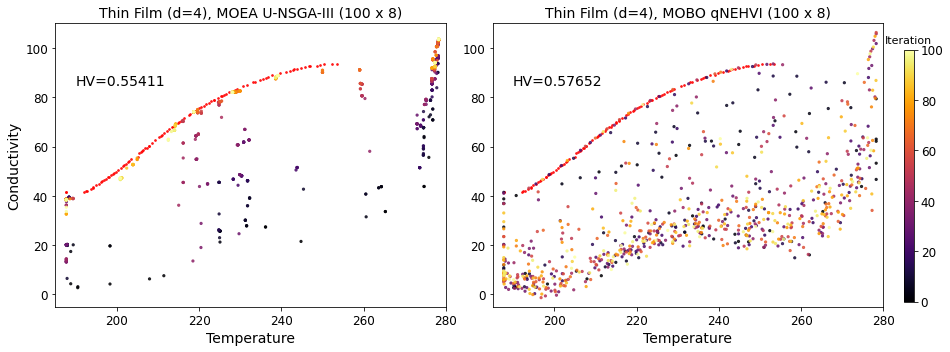

In [22]:
N_BATCH = 100
BATCH_SIZE = 8

cm = plt.cm.get_cmap('inferno')

batch_number = torch.cat([torch.zeros(2*(Problem.n_var+1)),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

algos = ["MOEA U-NSGA-III", "MOBO qNEHVI"]
col_list = [0, 1]
train_list = [train_nsga3, train_qnehvi]
hv_list = [hvs_nsga3, hvs_qnehvi]


fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

for i, train, hv in zip(col_list, train_list, hv_list):
    
    real_y1 = xscaler.inverse_transform(train[...,0:4])[...,-1]
    real_y2 = yscaler.inverse_transform(train[...,-1:]).ravel()
    
    ax[i].scatter(pareto_y1,
                  pareto_y2,
                 c='r', s=3, alpha=0.8)

    ax[i].scatter(real_y1,
                  real_y2,
                 c=batch_number, cmap=cm, s=5, alpha=0.8)
    '''
    ax[i].scatter(280,
                  6.331280245, 
                  c="r", s=100, marker="*")
    '''
    ax[i].set_title(f"Thin Film (d=4), {algos[i]} (100 x 8)", fontsize=14)
    ax[i].set_xlabel('Temperature', fontsize=14)
    
    ax[i].set_xlim(185, 280)
    ax[i].set_ylim(-5, 110)
    
    ax[i].text(190, 85, f'HV={hv[-1]:.5f}', fontsize=14)


ax[0].set_ylabel('Conductivity', fontsize=14)

fig.tight_layout()

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=11)